# 1. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.feature_extraction.text import  TfidfVectorizer, CountVectorizer
import re
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

### 1.1 add text features

In [2]:
def word_to_phrase(flist):
    plist = []
    if len(flist) > 0:
        for feature in flist:
            feature = re.sub('[_]',' ',feature)
            feature = feature.strip()
            feature_p = ''.join(feature.split(' '))
            plist.append(feature_p)
    return plist

def list_to_string(flist):
    string = ' '.join(flist)
    return string

In [78]:
ori_train = pd.read_json('train.json.zip', orient='columns', convert_dates=['created'], compression='zip')
ori_train = ori_train.reset_index()
ori_train.rename(columns={'index':'rec_id'}, inplace=True) 
train = ori_train
test =  pd.read_json('test.json.zip', orient='columns', convert_dates=['created'], compression='zip')
test = test.reset_index()
test.rename(columns={'index':'rec_id'}, inplace=True)

# remove outliers with ridiculously high prices
train = train[train['price']<=20000]
# remove outliers which the houses locate far away from most of the houses and missing values
train = train[(train['latitude'] <= 41.5) & (train['latitude'] >= 40) & (train['longitude'] >= -80) & (train['longitude'] <= -70)]
# remove outliers which have bathrooms more than bedrooms
train['diff_rooms'] = train['bedrooms'] - train['bathrooms']
train = train[train['diff_rooms']>=-1.5]

train_text = train[['description', 'features']]
test_text = test[['description', 'features']]
data_text = pd.concat([train_text, test_text], axis=0)

# tfidf
desc_tfidf = TfidfVectorizer(min_df=20, max_features=20, strip_accents='unicode',lowercase =True,
                        analyzer='word', token_pattern=r'\w{5,}', ngram_range=(1, 3),  sublinear_tf=True, stop_words = 'english')  
desc_tfidf_fit =desc_tfidf.fit_transform(data_text['description'])
desc_name = [x for x in desc_tfidf.get_feature_names()]
# standardize "feature"
data_text['features_phr'] = data_text['features'].apply(word_to_phrase)
data_text['features_phr_str'] = data_text['features_phr'].apply(list_to_string)
# tfidf 'feature'
phr_tfidf = TfidfVectorizer(min_df=2, max_features=20, strip_accents='unicode', lowercase=True, token_pattern=r'\w{3,}', stop_words='english')  
phr_tfidf_fit =phr_tfidf.fit_transform(data_text['features_phr_str'])
phr_names = [x for x in phr_tfidf.get_feature_names()]
data_text['features_phr_vec'] = pd.Series(phr_tfidf_fit.toarray().tolist())

In [79]:
phr_list = phr_tfidf_fit.toarray().tolist()
p_array=np.asarray(phr_list).reshape(123824, 20)
phr = pd.DataFrame(p_array, columns=["p_%d" % i for i in range(0, 20)])

desc_list = desc_tfidf_fit.toarray().tolist()
d_array=np.asarray(desc_list).reshape(123824, 20)
desc = pd.DataFrame(d_array, columns=["d_%d" % i for i in range(0, 20)])

In [80]:
text = phr.join([desc])
text

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19
0,0.0,0.269246,0.505923,0.288970,0.280043,0.000000,0.000000,0.000000,0.269265,0.0,...,0.205196,0.000000,0.000000,0.472793,0.266112,0.281430,0.000000,0.000000,0.000000,0.190534
1,0.0,0.000000,0.000000,0.411748,0.000000,0.410219,0.360214,0.000000,0.383669,0.0,...,0.000000,0.000000,0.000000,0.754272,0.000000,0.000000,0.000000,0.000000,0.000000,0.245240
2,0.0,0.000000,0.000000,0.383966,0.000000,0.382540,0.335909,0.000000,0.357782,0.0,...,0.159753,0.388263,0.218200,0.000000,0.000000,0.459813,0.209892,0.217943,0.215179,0.148338
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.259992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.350195,0.241414
4,0.0,0.000000,0.000000,0.000000,0.000000,0.474337,0.416516,0.589548,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.533560,0.000000,0.000000,0.000000,0.000000,0.382024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123819,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
123820,0.0,0.335651,0.000000,0.360240,0.349111,0.358902,0.315153,0.000000,0.335674,0.0,...,0.249172,0.000000,0.340334,0.000000,0.323143,0.341743,0.000000,0.000000,0.000000,0.231367
123821,0.0,0.693074,0.000000,0.000000,0.720867,0.000000,0.000000,0.000000,0.000000,0.0,...,0.170358,0.000000,0.000000,0.486522,0.000000,0.233649,0.223826,0.232411,0.229463,0.000000
123822,0.0,0.493459,0.000000,0.000000,0.513247,0.527642,0.463324,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.409033,0.389804,0.000000,0.000000,0.000000,0.000000,0.000000


### 1.2 Remove correlated columns

In [81]:
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped

def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped

In [82]:
# drop correlated columns
columns_dropped_corr = remove_correlated_features(text)
columns_dropped_corr 

Index(['p_19', 'd_9', 'd_14', 'd_17', 'd_18'], dtype='object')

In [83]:
ori_train=pd.read_json("modified_data/modified_train.json")
ori_test = pd.read_json("modified_data/modified_test.json")

ori_train = ori_train.drop(columns=['rec_id', 'building_id','description','display_address','manager_id','features','photos','street_address','features_phr_vec','description_vec','text_vec'])
ori_train = ori_train.reset_index()
train = ori_train.join(text)

ori_test = ori_test.drop(columns=['rec_id', 'building_id','description','display_address','manager_id','features','photos','street_address','features_phr_vec','description_vec','text_vec'])
ori_test = ori_test.reset_index()
test = ori_test.join(text)

Listing_id_train = train['listing_id']
y_train = train['interest_level']
X_train = train.drop(columns=['index','listing_id', 'interest_level', 'diff_rooms'])

Listing_id_test = test['listing_id']
X_test = test.drop(columns=['index', 'listing_id'])

y_train_map = {"low":0, "medium": 1, "high": 2}
y_train = y_train.map(y_train_map)

In [84]:
X = pd.concat([X_train, X_test])
X_train = X[:49165]
X_test = X[49165:]

In [85]:
subway_test = pd.read_csv("subway_test.csv")
subway_train = pd.read_csv("subway_train.csv")
X_train['price_per_bedroom'] = X_train['price']/(X_train['bedrooms']+1)
X_train['price_per_bathroom'] = X_train['price']/(X_train['bathrooms']+1)
X_test['price_per_bedroom'] = X_test['price']/(X_test['bedrooms']+1)
X_test['price_per_bathroom'] = X_test['price']/(X_test['bathrooms']+1)
X_train['distance_subway'] = subway_train.distance_subway
X_test['distance_subway'] = subway_test.distance_subway

<ipython-input-85-aa2eff42c96a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['price_per_bedroom'] = X_train['price']/(X_train['bedrooms']+1)
<ipython-input-85-aa2eff42c96a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['price_per_bathroom'] = X_train['price']/(X_train['bathrooms']+1)
<ipython-input-85-aa2eff42c96a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [86]:
X_test

,bathrooms,bedrooms,created,latitude,longitude,price,manager_id_num,building_id_num,photo_num,p_0,...,d_10,d_11,d_12,d_13,d_15,d_16,d_19,price_per_bedroom,price_per_bathroom,distance_subway
0,1.0,1,1465622981000,40.7185,-73.9865,2950,3071,5524,8,0.0,...,0.205196,0.000000,0.000000,0.472793,0.281430,0.000000,0.190534,1475.000000,1475.000000,81.603311
1,1.0,2,1466750194000,40.7278,-74.0000,2850,3587,0,3,0.0,...,0.000000,0.000000,0.000000,0.754272,0.000000,0.000000,0.245240,950.000000,1425.000000,360.366494
2,1.0,0,1466126619000,40.7260,-74.0026,2295,3952,0,1,0.0,...,0.159753,0.388263,0.218200,0.000000,0.459813,0.209892,0.148338,2295.000000,1147.500000,99.244353
3,1.0,2,1466485562000,40.7321,-74.0028,2900,1136,11318,4,0.0,...,0.259992,0.000000,0.000000,0.000000,0.000000,0.000000,0.241414,966.666667,1450.000000,147.270775
4,1.0,1,1466061867000,40.7054,-74.0095,3254,2871,5864,6,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382024,1627.000000,1627.000000,161.565385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74654,1.0,1,1461686995000,40.7925,-73.9454,1700,1207,8607,10,0.0,...,0.183816,0.000000,0.251068,0.250145,0.252107,0.000000,0.170682,850.000000,850.000000,274.294950
74655,1.0,2,1461215179000,40.7456,-73.9797,4195,743,6588,4,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1398.333333,2097.500000,207.183160
74656,1.0,0,1461115912000,40.7416,-73.9829,2400,3952,0,0,0.0,...,0.000000,0.763200,0.428912,0.000000,0.000000,0.000000,0.291584,2400.000000,1200.000000,199.807524
74657,2.0,2,1460082405000,40.7485,-73.9800,6895,1879,9114,8,0.0,...,0.209209,0.300306,0.000000,0.482040,0.000000,0.000000,0.000000,2298.333333,2298.333333,320.834714


### 1.3 PCA and Scaler

#### Standard Scaler

In [93]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# apply standard scalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = X_scaled[:49165]
X_test_scaled = X_scaled[49165:]

In [87]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# apply standard scalar
scaler = MinMaxScaler(feature_range=[0, 1])
X_scaled = scaler.fit_transform(X)
X_train_scaled = X_scaled[:49165]
X_test_scaled = X_scaled[49165:]

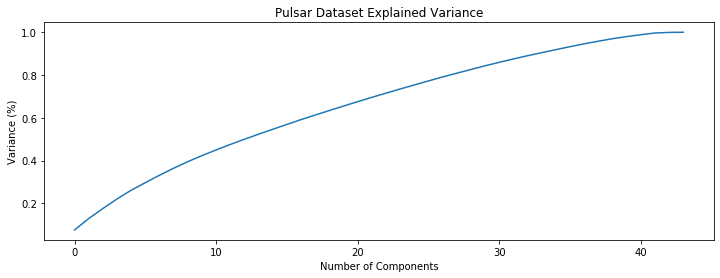

In [99]:
# Fitting the PCA algorithm
import matplotlib.pyplot as plt
pca = PCA().fit(X_scaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.savefig('pca.png',dpi=800)

This plot tells us that selecting 90 components to preserce around 99% of the original information

In [75]:
# apply PCA
pca = PCA(n_components=10)
X_scaled = pca.fit_transform(X_scaled)
X_train_scaled = X_scaled[:49165]
X_test_scaled = X_scaled[49165:]

### 1.4 output function

In [89]:
def to_result_format(X):
    res = pd.DataFrame(y_test,columns=['high', 'low', 'medium'])
    temp = res['low']
    res = res.drop(columns = {'low'})
    res.insert(2,'low',temp)
    res.insert
    res.insert(0,'listing_id',X['listing_id'])
    res.to_csv('submission.csv', index = None)
    return res

### 1.5 GridSearchCV

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

def tuneParameters(X, y, tuned_parameters):
    score = 'accuracy'
    
    print('# Tuning hyper-parameters for %s' % score)
    print()

    cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
    grid = GridSearchCV(
        GradientBoostingClassifier(), param_grid=tuned_parameters,scoring=score, cv=cv, n_jobs=-1
    )
    grid.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()


    return grid

### 1.6 Modelfit

In [90]:
from sklearn import metrics
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

def modelfit(alg, X_train_scaled, y_train, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    bound = int(len(X_train_scaled) / 5 * 4 )
    X_tr = X_train_scaled[:bound]
    y_tr = y_train[:bound]
    X_va = X_train_scaled[bound:]
    y_va = y_train[bound:]
    alg.fit(X_tr, y_tr)
    

        
    #Predict training set:
    dtrain_predictions = alg.predict(X_va)
    dtrain_predprob = alg.predict_proba(X_va)
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='neg_log_loss')
    
    #Print model report:
    print("\nModel Report")
    print("Logloss : %.4f" % metrics.log_loss(y_va, dtrain_predprob))
    print("Accuracy : %.4g" % metrics.accuracy_score(y_va, dtrain_predictions))
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(y_va, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, range(0,len(alg.feature_importances_))).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

# 2. GBDT (1st attempt)

In [97]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.6, random_state=0, min_impurity_decrease=0.0007,max_leaf_nodes=80, min_samples_leaf=5 )
clf.fit(X_train_scaled, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.6, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=80,
                           min_impurity_decrease=0.0007,
                           min_impurity_split=None, min_samples_leaf=5,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           presort='deprecated', random_state=0, subsample=1.0,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [30]:
scores = cross_val_score(clf, X_train_scaled, y_train, cv=5)
print('Cross Validation Score = %0.3f (+/-%0.03f)'% (scores.mean(), scores.std() * 2) )

Cross Validation Score = 0.690 (+/-0.005)


In [98]:
y_test = clf.predict_proba(X_test_scaled)

# change the order of columns in result
y_test_df = pd.DataFrame(y_test)
cols = y_test_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
y_test = y_test_df[cols].to_numpy()

X_test_df = pd.DataFrame(X_test).join([Listing_id_test])
res = to_result_format(X_test_df)
res

,listing_id,high,medium,low
0,7142618,0.054197,0.391321,0.554482
1,7210040,0.309888,0.278315,0.411797
2,7174566,0.033835,0.194220,0.771945
3,7191391,0.290854,0.412416,0.296729
4,7171695,0.003706,0.189543,0.806751
...,...,...,...,...
74654,6928108,0.892790,0.092230,0.014980
74655,6906674,0.013830,0.081022,0.905149
74656,6897967,0.001462,0.016271,0.982267
74657,6842183,0.004348,0.046089,0.949563


### Score:
#### CV score =  0.690 (+/-0.005)
#### Logloss   = 0.83833


Model Report
Logloss : 0.7360
Accuracy : 0.6907
CV Score : Mean - -0.620131 | Std - 0.005837624 | Min - -0.627958 | Max - -0.6123068


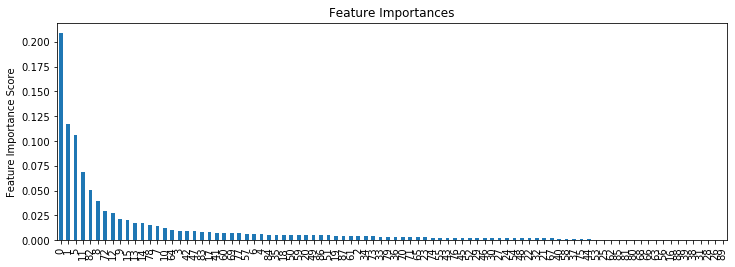

In [34]:
modelfit(clf, X_train_scaled, y_train, False)

# 3. GBDT (parameter tuning)

### Print Result Function

In [35]:
def print_gsearch_result(grid):
    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.6f (+/-%0.6f) for %r"
              % (mean, std * 2, params))
    print()

### 3.1 Tuning Boosting Parameters

In [106]:
def tuneParameters1(X, y, tuned_parameters):
    score = 'neg_log_loss'
    
    print('# Tuning hyper-parameters for %s' % score)
    print()

    cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    grid = GridSearchCV(
        estimator=GradientBoostingClassifier(random_state=0, min_impurity_decrease=0.0007,max_leaf_nodes=80, min_samples_leaf=5), 
        param_grid=tuned_parameters,scoring=score, cv=cv, n_jobs=8
    )
    grid.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.6f (+/-%0.6f) for %r"
              % (mean, std * 2, params))
    print()


    return grid

* Set candidate values for n_estimators and learning_rate:

n_estimators : [40, 50, 60, 70]

learning_rate: [0.05, 0.1, 0.15, 0.2]

* Set initial values for other parameters

min_samples_leaf=50, min_samples_split=500, max_depth=8, max_features='sqrt', subsample=0.8, random_state=10

In [101]:
tuned_parameters1 = [{'n_estimators': [40, 50, 60, 70], 'learning_rate': [0.05, 0.1, 0.15, 0.2]}]

grid1 = tuneParameters1(X_train_scaled, y_train, tuned_parameters1)

# Tuning hyper-parameters for neg_log_loss

Best parameters set found on development set:

{'learning_rate': 0.2, 'n_estimators': 70}

Grid scores on development set:

-0.666610 (+/-0.001357) for {'learning_rate': 0.05, 'n_estimators': 40}
-0.657663 (+/-0.002367) for {'learning_rate': 0.05, 'n_estimators': 50}
-0.650285 (+/-0.001554) for {'learning_rate': 0.05, 'n_estimators': 60}
-0.644459 (+/-0.000717) for {'learning_rate': 0.05, 'n_estimators': 70}
-0.639063 (+/-0.000333) for {'learning_rate': 0.1, 'n_estimators': 40}
-0.631937 (+/-0.000533) for {'learning_rate': 0.1, 'n_estimators': 50}
-0.626747 (+/-0.000723) for {'learning_rate': 0.1, 'n_estimators': 60}
-0.622397 (+/-0.000594) for {'learning_rate': 0.1, 'n_estimators': 70}
-0.626237 (+/-0.001159) for {'learning_rate': 0.15, 'n_estimators': 40}
-0.619820 (+/-0.002093) for {'learning_rate': 0.15, 'n_estimators': 50}
-0.614570 (+/-0.001483) for {'learning_rate': 0.15, 'n_estimators': 60}
-0.610033 (+/-0.003024) for {'learning_rate'

In [103]:
y_test = grid1.predict_proba(X_test_scaled)

# change the order of columns in result
y_test_df = pd.DataFrame(y_test)
cols = y_test_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
y_test = y_test_df[cols].to_numpy()

X_test_df = pd.DataFrame(X_test).join([Listing_id_test])
res = to_result_format(X_test_df)
res

,listing_id,high,medium,low
0,7142618,0.054851,0.344574,0.600576
1,7210040,0.163570,0.244059,0.592371
2,7174566,0.034143,0.180775,0.785082
3,7191391,0.216204,0.381461,0.402335
4,7171695,0.012813,0.087449,0.899738
...,...,...,...,...
74654,6928108,0.651786,0.257902,0.090312
74655,6906674,0.031132,0.153044,0.815824
74656,6897967,0.007577,0.037418,0.955005
74657,6842183,0.012906,0.067434,0.919661


Kaggle score = 0.66507 

#### (1) Tuning the number of estimators

In [105]:
tuned_parameters2 = [{'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100], 'learning_rate': [0.1]}]

grid2 = tuneParameters1(X_train_scaled, y_train, tuned_parameters2)

# Tuning hyper-parameters for neg_log_loss

Best parameters set found on development set:

{'learning_rate': 0.1, 'n_estimators': 100}

Grid scores on development set:

-0.665914 (+/-0.000967) for {'learning_rate': 0.1, 'n_estimators': 20}
-0.649624 (+/-0.001902) for {'learning_rate': 0.1, 'n_estimators': 30}
-0.639063 (+/-0.000333) for {'learning_rate': 0.1, 'n_estimators': 40}
-0.631937 (+/-0.000533) for {'learning_rate': 0.1, 'n_estimators': 50}
-0.626747 (+/-0.000723) for {'learning_rate': 0.1, 'n_estimators': 60}
-0.622397 (+/-0.000594) for {'learning_rate': 0.1, 'n_estimators': 70}
-0.618338 (+/-0.000570) for {'learning_rate': 0.1, 'n_estimators': 80}
-0.614678 (+/-0.001155) for {'learning_rate': 0.1, 'n_estimators': 90}
-0.611727 (+/-0.001663) for {'learning_rate': 0.1, 'n_estimators': 100}



Notice the best n_estimators is too high ~100, which means tuning other parameters will take too much time. 

We have to __try a higher learning rate__ to improve the efficiency.

In [107]:
tuned_parameters3 = [{'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100], 'learning_rate': [0.2]}]

grid3 = tuneParameters1(X_train_scaled, y_train, tuned_parameters3)

# Tuning hyper-parameters for neg_log_loss

Best parameters set found on development set:

{'learning_rate': 0.2, 'n_estimators': 100}

Grid scores on development set:

-0.639093 (+/-0.000000) for {'learning_rate': 0.2, 'n_estimators': 20}
-0.626079 (+/-0.000000) for {'learning_rate': 0.2, 'n_estimators': 30}
-0.617756 (+/-0.000000) for {'learning_rate': 0.2, 'n_estimators': 40}
-0.610639 (+/-0.000000) for {'learning_rate': 0.2, 'n_estimators': 50}
-0.605332 (+/-0.000000) for {'learning_rate': 0.2, 'n_estimators': 60}
-0.601880 (+/-0.000000) for {'learning_rate': 0.2, 'n_estimators': 70}
-0.597556 (+/-0.000000) for {'learning_rate': 0.2, 'n_estimators': 80}
-0.594137 (+/-0.000000) for {'learning_rate': 0.2, 'n_estimators': 90}
-0.591834 (+/-0.000000) for {'learning_rate': 0.2, 'n_estimators': 100}



In [110]:
tuned_parameters4 = [{'n_estimators': [40, 50, 60, 70, 80, 90, 100], 'learning_rate': [0.25]}]

grid4 = tuneParameters1(X_train_scaled, y_train, tuned_parameters4)

# Tuning hyper-parameters for neg_log_loss

Best parameters set found on development set:

{'learning_rate': 0.25, 'n_estimators': 100}

Grid scores on development set:

-0.609965 (+/-0.000000) for {'learning_rate': 0.25, 'n_estimators': 40}
-0.603525 (+/-0.000000) for {'learning_rate': 0.25, 'n_estimators': 50}
-0.599225 (+/-0.000000) for {'learning_rate': 0.25, 'n_estimators': 60}
-0.596061 (+/-0.000000) for {'learning_rate': 0.25, 'n_estimators': 70}
-0.592417 (+/-0.000000) for {'learning_rate': 0.25, 'n_estimators': 80}
-0.589130 (+/-0.000000) for {'learning_rate': 0.25, 'n_estimators': 90}
-0.586471 (+/-0.000000) for {'learning_rate': 0.25, 'n_estimators': 100}



In [113]:
tuned_parameters5 = [{'n_estimators': [60, 70, 80, 90, 100], 'learning_rate': [0.35]}]

grid5 = tuneParameters1(X_train_scaled, y_train, tuned_parameters5)

# Tuning hyper-parameters for neg_log_loss

Best parameters set found on development set:

{'learning_rate': 0.35, 'n_estimators': 100}

Grid scores on development set:

-0.591271 (+/-0.000000) for {'learning_rate': 0.35, 'n_estimators': 60}
-0.587181 (+/-0.000000) for {'learning_rate': 0.35, 'n_estimators': 70}
-0.584045 (+/-0.000000) for {'learning_rate': 0.35, 'n_estimators': 80}
-0.582469 (+/-0.000000) for {'learning_rate': 0.35, 'n_estimators': 90}
-0.581033 (+/-0.000000) for {'learning_rate': 0.35, 'n_estimators': 100}



In [115]:
tuned_parameters6 = [{'n_estimators': [60, 70, 80, 90, 100], 'learning_rate': [0.5]}]

grid6 = tuneParameters1(X_train_scaled, y_train, tuned_parameters6)

# Tuning hyper-parameters for neg_log_loss

Best parameters set found on development set:

{'learning_rate': 0.5, 'n_estimators': 100}

Grid scores on development set:

-0.587388 (+/-0.000000) for {'learning_rate': 0.5, 'n_estimators': 60}
-0.584236 (+/-0.000000) for {'learning_rate': 0.5, 'n_estimators': 70}
-0.582616 (+/-0.000000) for {'learning_rate': 0.5, 'n_estimators': 80}
-0.581709 (+/-0.000000) for {'learning_rate': 0.5, 'n_estimators': 90}
-0.580267 (+/-0.000000) for {'learning_rate': 0.5, 'n_estimators': 100}



In [119]:
clf1 = GradientBoostingClassifier(n_estimators =800, learning_rate=0.1, random_state=0, min_impurity_decrease=0.0007,max_leaf_nodes=80, min_samples_leaf=5)
clf1.fit(X_train_scaled, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=80,
                           min_impurity_decrease=0.0007,
                           min_impurity_split=None, min_samples_leaf=5,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=800, n_iter_no_change=None,
                           presort='deprecated', random_state=0, subsample=1.0,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [120]:
y_test = clf1.predict_proba(X_test_scaled)

# change the order of columns in result
y_test_df = pd.DataFrame(y_test)
cols = y_test_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
y_test = y_test_df[cols].to_numpy()

X_test_df = pd.DataFrame(X_test).join([Listing_id_test])
res = to_result_format(X_test_df)
res

,listing_id,high,medium,low
0,7142618,0.051667,0.389245,0.559088
1,7210040,0.238267,0.309791,0.451942
2,7174566,0.053564,0.177920,0.768516
3,7191391,0.242074,0.551516,0.206410
4,7171695,0.006920,0.089323,0.903757
...,...,...,...,...
74654,6928108,0.859732,0.120271,0.019997
74655,6906674,0.015127,0.076559,0.908314
74656,6897967,0.000983,0.027078,0.971939
74657,6842183,0.004933,0.066830,0.928238


Now we have the optimal n_estimators for learning rate 0.25.

Notice 60 is a reasonable value for n_estimators. 

We will use {n_estimators=60, learning_rate=0.25} for the following parameter tuning

### 3. 2. Tuning Tree Parameters with Fixed n_estimators and learning_rate

#### 3.2.1 Tuning max_depth and min_sample_split

Tuning max_depth and min_sample_split first, because these parameters have biggest impact on the performace

In [55]:
param_test1 = {'max_depth': range(3,16,2), 'min_samples_split': range(1000, 2001, 200)}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
gsearch1 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.25, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10),
                       param_grid=param_test1, scoring='neg_log_loss', n_jobs=-1, cv=cv)
gsearch1.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=2, random_state=42, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.25,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_le...
                                                  n_estimators=60,
                                                  n_iter_no_change=None,
                                                  pre

In [56]:
print_gsearch_result(gsearch1)

Best parameters set found on development set:

{'max_depth': 13, 'min_samples_split': 2000}

Grid scores on development set:

-0.717167 (+/-0.007156) for {'max_depth': 3, 'min_samples_split': 1000}
-0.717560 (+/-0.005535) for {'max_depth': 3, 'min_samples_split': 1200}
-0.717727 (+/-0.003717) for {'max_depth': 3, 'min_samples_split': 1400}
-0.718157 (+/-0.007042) for {'max_depth': 3, 'min_samples_split': 1600}
-0.718666 (+/-0.006163) for {'max_depth': 3, 'min_samples_split': 1800}
-0.719262 (+/-0.007316) for {'max_depth': 3, 'min_samples_split': 2000}
-0.709447 (+/-0.011057) for {'max_depth': 5, 'min_samples_split': 1000}
-0.709795 (+/-0.007589) for {'max_depth': 5, 'min_samples_split': 1200}
-0.710434 (+/-0.006977) for {'max_depth': 5, 'min_samples_split': 1400}
-0.709941 (+/-0.008741) for {'max_depth': 5, 'min_samples_split': 1600}
-0.711771 (+/-0.006828) for {'max_depth': 5, 'min_samples_split': 1800}
-0.710736 (+/-0.009388) for {'max_depth': 5, 'min_samples_split': 2000}
-0.708124 

In [57]:
param_test2 = {'max_depth': range(5,11,1), 'min_samples_split': range(600, 1401, 200)}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
gsearch2 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.25, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10),
                       param_grid=param_test2, scoring='neg_log_loss', n_jobs=-1, cv=cv)
gsearch2.fit(X_train_scaled, y_train)
print_gsearch_result(gsearch2)

Best parameters set found on development set:

{'max_depth': 10, 'min_samples_split': 1400}

Grid scores on development set:

-0.708469 (+/-0.009697) for {'max_depth': 5, 'min_samples_split': 600}
-0.709950 (+/-0.005765) for {'max_depth': 5, 'min_samples_split': 800}
-0.709630 (+/-0.007952) for {'max_depth': 5, 'min_samples_split': 1000}
-0.709422 (+/-0.006122) for {'max_depth': 5, 'min_samples_split': 1200}
-0.708931 (+/-0.006054) for {'max_depth': 5, 'min_samples_split': 1400}
-0.707619 (+/-0.006219) for {'max_depth': 6, 'min_samples_split': 600}
-0.708617 (+/-0.006972) for {'max_depth': 6, 'min_samples_split': 800}
-0.706187 (+/-0.005531) for {'max_depth': 6, 'min_samples_split': 1000}
-0.706971 (+/-0.006025) for {'max_depth': 6, 'min_samples_split': 1200}
-0.708087 (+/-0.007081) for {'max_depth': 6, 'min_samples_split': 1400}
-0.705348 (+/-0.009927) for {'max_depth': 7, 'min_samples_split': 600}
-0.704966 (+/-0.006073) for {'max_depth': 7, 'min_samples_split': 800}
-0.706326 (+/-0.


Model Report
Logloss : 0.7062
Accuracy : 0.6936


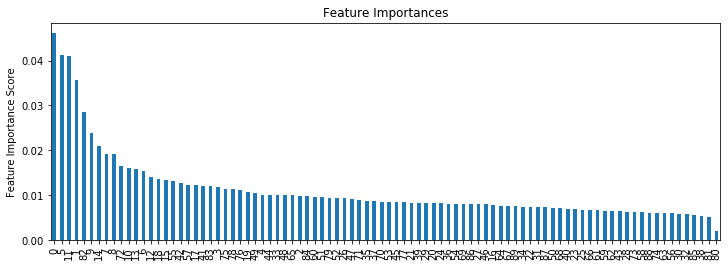

In [58]:
modelfit(gsearch2.best_estimator_, X_train_scaled, y_train, False)

In [59]:
param_test3 = {'max_depth': range(10,21,2), 'min_samples_split': range(1400, 2401, 200)}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
gsearch3 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.25, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10),
                       param_grid=param_test3, scoring='neg_log_loss', n_jobs=-1, cv=cv)
gsearch3.fit(X_train_scaled, y_train)
print_gsearch_result(gsearch3)

Best parameters set found on development set:

{'max_depth': 10, 'min_samples_split': 1400}

Grid scores on development set:

-0.704661 (+/-0.010145) for {'max_depth': 10, 'min_samples_split': 1400}
-0.705203 (+/-0.009643) for {'max_depth': 10, 'min_samples_split': 1600}
-0.706586 (+/-0.008039) for {'max_depth': 10, 'min_samples_split': 1800}
-0.707730 (+/-0.008144) for {'max_depth': 10, 'min_samples_split': 2000}
-0.708238 (+/-0.009517) for {'max_depth': 10, 'min_samples_split': 2200}
-0.707346 (+/-0.009178) for {'max_depth': 10, 'min_samples_split': 2400}
-0.707663 (+/-0.012145) for {'max_depth': 12, 'min_samples_split': 1400}
-0.706052 (+/-0.006328) for {'max_depth': 12, 'min_samples_split': 1600}
-0.706497 (+/-0.010839) for {'max_depth': 12, 'min_samples_split': 1800}
-0.705171 (+/-0.014264) for {'max_depth': 12, 'min_samples_split': 2000}
-0.706843 (+/-0.007910) for {'max_depth': 12, 'min_samples_split': 2200}
-0.708794 (+/-0.009362) for {'max_depth': 12, 'min_samples_split': 2400

We find the optimal value for max_depth is 10. And the optimal value for min_samples_split is 1400.

Also, we can test for 5 values of min_samples_leaf, from 30 to 70 in steps of 10.

#### 3.2.2 Tuning min_samples_leaf

In [63]:
param_test4 = {'min_samples_leaf': range(30,71,10)}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
gsearch4 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.25, n_estimators=60, max_features='sqrt', subsample=0.8,max_depth=10,min_samples_split=1400, random_state=10),
                       param_grid=param_test4, scoring='neg_log_loss', n_jobs=-1, cv=cv)
gsearch4.fit(X_train_scaled, y_train)
print_gsearch_result(gsearch4)

Best parameters set found on development set:

{'min_samples_leaf': 40}

Grid scores on development set:

-0.704057 (+/-0.007674) for {'min_samples_leaf': 30}
-0.701087 (+/-0.013143) for {'min_samples_leaf': 40}
-0.701220 (+/-0.011412) for {'min_samples_leaf': 50}
-0.702078 (+/-0.012287) for {'min_samples_leaf': 60}
-0.703242 (+/-0.011673) for {'min_samples_leaf': 70}



From the above result, we find the optimal value of min_samples_leaf is 40. 

#### Now we have {'max_depth': 10, 'min_samples_split': 1400, 'min_samples_leaf': 40}.



Model Report
Logloss : 0.7020
Accuracy : 0.6968


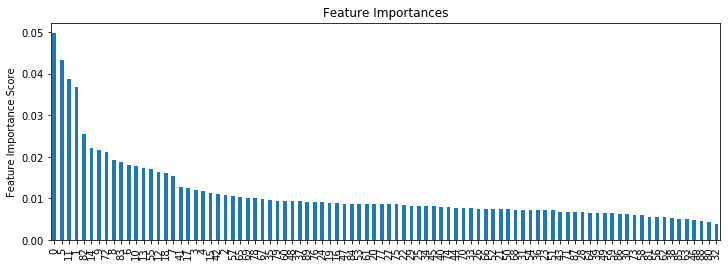

In [64]:
modelfit(gsearch4.best_estimator_, X_train_scaled, y_train, False)

#### 3.2.3 Tuning max_features

In [65]:
param_test5 = {'max_features':  range(7,20,2)}
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
gsearch5 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.25, n_estimators=60, subsample=0.8,max_depth=10, min_samples_split=1400,min_samples_leaf=40, random_state=10),
                       param_grid=param_test5, scoring='neg_log_loss', n_jobs=-1, cv=cv)
gsearch5.fit(X_train_scaled, y_train)
print_gsearch_result(gsearch5)

Best parameters set found on development set:

{'max_features': 19}

Grid scores on development set:

-0.702980 (+/-0.007124) for {'max_features': 7}
-0.701087 (+/-0.013143) for {'max_features': 9}
-0.701635 (+/-0.011105) for {'max_features': 11}
-0.700881 (+/-0.015205) for {'max_features': 13}
-0.701542 (+/-0.008739) for {'max_features': 15}
-0.701010 (+/-0.014151) for {'max_features': 17}
-0.699916 (+/-0.012198) for {'max_features': 19}



In [66]:
param_test6 = {'max_features':  range(19,30,2)}
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
gsearch6 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.25, n_estimators=60, subsample=0.8,max_depth=10, min_samples_split=1400,min_samples_leaf=40, random_state=10),
                       param_grid=param_test6, scoring='neg_log_loss', n_jobs=-1, cv=cv)
gsearch6.fit(X_train_scaled, y_train)
print_gsearch_result(gsearch6)

Best parameters set found on development set:

{'max_features': 29}

Grid scores on development set:

-0.699916 (+/-0.012198) for {'max_features': 19}
-0.703082 (+/-0.009758) for {'max_features': 21}
-0.702704 (+/-0.014264) for {'max_features': 23}
-0.702660 (+/-0.008581) for {'max_features': 25}
-0.700809 (+/-0.013885) for {'max_features': 27}
-0.698774 (+/-0.010768) for {'max_features': 29}



In [67]:
param_test7 = {'max_features':  range(31,36,2)}
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
gsearch7 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.25, n_estimators=60, subsample=0.8,max_depth=10, min_samples_split=1400,min_samples_leaf=40, random_state=10),
                       param_grid=param_test7, scoring='neg_log_loss', n_jobs=-1, cv=cv)
gsearch7.fit(X_train_scaled, y_train)
print_gsearch_result(gsearch7)

Best parameters set found on development set:

{'max_features': 33}

Grid scores on development set:

-0.701405 (+/-0.009701) for {'max_features': 31}
-0.701299 (+/-0.011018) for {'max_features': 33}
-0.701890 (+/-0.016175) for {'max_features': 35}



The optimal value for max_features is 29.

#### 3.2.4 Tuning subsample

In [68]:
param_test8 = {'subsample':[0.6,0.7, 0.75, 0.8, 0.85, 0.9]}
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
gsearch8 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.25, n_estimators=60,max_depth=10, min_samples_split=1400,min_samples_leaf=40, max_features=29, random_state=10),
                       param_grid=param_test8, scoring='neg_log_loss', n_jobs=-1, cv=cv)
gsearch8.fit(X_train_scaled, y_train)
print_gsearch_result(gsearch8)

Best parameters set found on development set:

{'subsample': 0.8}

Grid scores on development set:

-0.707740 (+/-0.012529) for {'subsample': 0.6}
-0.705304 (+/-0.012300) for {'subsample': 0.7}
-0.701922 (+/-0.007805) for {'subsample': 0.75}
-0.698774 (+/-0.010768) for {'subsample': 0.8}
-0.699612 (+/-0.011668) for {'subsample': 0.85}
-0.700474 (+/-0.010964) for {'subsample': 0.9}



### 3.3 Proportionally increase n_estimators and decrease learning_rate

In [70]:
clf1 = GradientBoostingClassifier(learning_rate=0.125, n_estimators=120,
                                  max_depth=10, min_samples_split=1400,min_samples_leaf=40, max_features=29, random_state=10)
clf1.fit(X_train_scaled, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.125, loss='deviance', max_depth=10,
                           max_features=29, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=40, min_samples_split=1400,
                           min_weight_fraction_leaf=0.0, n_estimators=120,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# 4. Evaluation

In [121]:
clf2 = GradientBoostingClassifier(n_estimators =200, learning_rate=0.1, random_state=0, min_impurity_decrease=0.0007,max_leaf_nodes=80, min_samples_leaf=5)

In [126]:
from sklearn.model_selection import KFold, cross_val_score
def crossValidation(clf, X, y, n):
    cv = KFold(n_splits=n)
    y_pred = []
    i=0
    # split the training data to training and validation data
    for train_index, valid_index in cv.split(X):
        print("loop %d" % i)
        i += 1
        X_tr, X_va, y_tr, y_va = X[train_index], X[valid_index], y.iloc[train_index], y.iloc[valid_index]
        clf.fit(X_tr, y_tr)
        y_pred.append(clf.predict(X_va))
        break
    return y_pred
    

In [127]:
y_pred = crossValidation(clf2, X_train_scaled, y_train, 5)

loop 0


In [132]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
def cm_plot(y_valid,y_pred):
    cm = confusion_matrix(y_valid, y_pred, labels = [0,1,2])
    cm = pd.DataFrame(cm,columns=['low','medium','high'],index = ['low','medium','high'])
    plt.title('Confusion Matrix',fontsize=18)
    ax = sns.heatmap(cm,annot=True,cmap='YlGn_r',fmt='.20g',linewidths = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted Label',fontsize=12)
    plt.ylabel('True Label',fontsize=12)
    plt.savefig('cm.png',dpi=800)

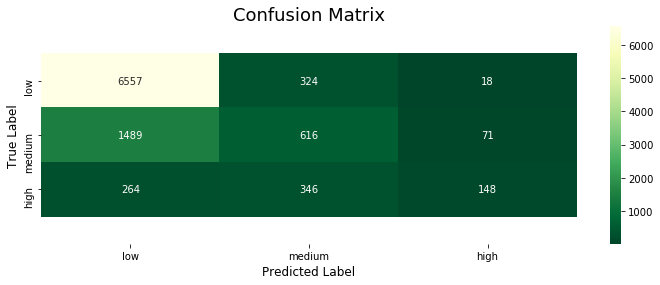

In [133]:
n = int( len(y_train) / 5 )
y_valid = y_train[:n]
y_p = np.asarray(y_pred).reshape(n,1)
cm_plot(y_valid, y_p)